In [1]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

total_consumption_production = datastore.getTotalConsumptionProduction()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

transTo = datastore.getTransmissionCapTo()
transFrom = datastore.getTransmissionCapFrom()

# netFlow = datastore.getNetFlow() # Too many missing values
flow = datastore.getFlow()

capTo = datastore.getFlowCapacityTo()
capFrom = datastore.getFlowCapacityFrom()

exchangeFrom = datastore.getExchangeFrom()
# exchangeNet = datastore.getNetExchange()

turnOver = datastore.getTurnover()

pen = datastore.getDailyPerc() 
hydroReservoirs = datastore.getWeeklyHydro() # GWh

windspeeds = pd.read_csv('windspeeds_aggregated.csv' , sep=';', parse_dates=True, index_col=0)
temp = pd.read_csv('temp_agg.csv' , sep=';', parse_dates=True, index_col=0)

Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionGWh', 'ProductionGWh'], dtype='object') : 14
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 46
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 144
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 139
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 155
Missing values in Index(['TDK1SE3', 'TNO1SE3', 'TSE2SE3', 'TF1SE3', 'TSE4SE3'], dtype='object') : 0
Missing values in Index(['TSE3DK1', 'TSE3NO1', 'TSE3SE2', 'TSE3F1', 'TSE3SE4'], dtype='object') : 0
Missing values in Index(['F_LOWSE2SE3', 'F_LOWSE3FI', 'F_LOWSE3SE4'], dtype='object') : 5738
Missing values in Index(['C_SE4SE3', 'C_DK1SE3', 'C_FISE3', 'C_NO1SE3', 'C_SE2SE3'], 

In [36]:
import calendar_features as cf

dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh,  
                     flow, capTo, capFrom, exchangeFrom,
                     turnOver, pen, hydroReservoirs, windspeeds, temp, transTo, transFrom], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# daylight_features = cf.daylight_extractor(dataset)    
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
dataset = pd.get_dummies(dataset, columns=["year", "month", "day_of_week", "hour"])
dataset['weekend'] = dataset['weekend'].astype('bool')
dataset['holidays'] = dataset['holidays'].astype('bool')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52584 entries, 2018-01-01 00:00:00 to 2023-12-31 23:00:00
Columns: 114 entries, spotPrice to hour_23
dtypes: bool(2), float64(63), uint8(49)
memory usage: 30.2 MB


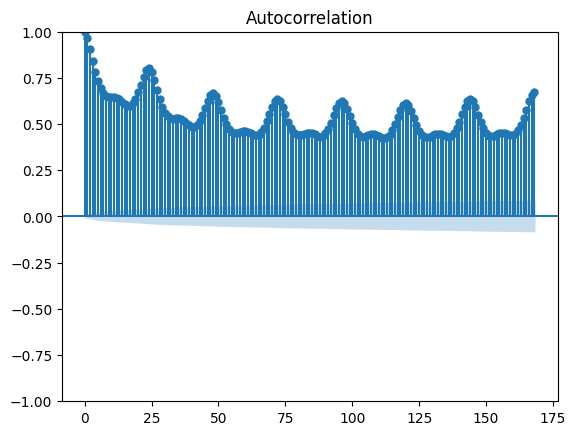

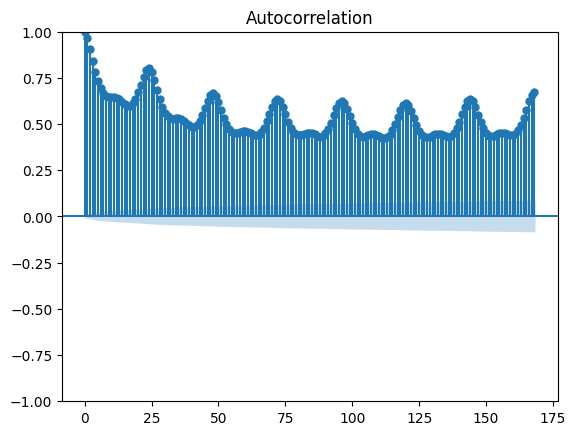

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(spot, lags=168, alpha=0.05, missing='drop')

In [21]:
spot_lag_24 = spot.shift(24).add_suffix('_24')
spot_lag_48 = spot.shift(48).add_suffix('_48')
spot_lag_72 = spot.shift(72).add_suffix('_72')
spot_lag_96 = spot.shift(96).add_suffix('_96')
spot_lag_120 = spot.shift(120).add_suffix('_120')
spot_lag_168 = spot.shift(168).add_suffix('_168')

dataset = pd.concat([spot_lag_24, spot_lag_48, spot_lag_72, spot_lag_96, spot_lag_120, spot_lag_168
                    ,dataset]
                    ,axis=1)
dataset = dataset.dropna()

first_col = dataset.pop('spotPrice')
dataset.insert(0, 'spotPrice', first_col)

In [ ]:
import calendar_features as cf
from feature_engine.creation import CyclicalFeatures


dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh,  
                     flow, capTo, capFrom, exchangeFrom, exchangeTo,
                     turnOver, windspeeds, hydroReservoirs, pen, temp, transTo, transFrom], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
cyclical = CyclicalFeatures(variables=['year', 'month', 'day_of_week', 'hour', 'holidays', 'weekend'], drop_original=True)
dataset = cyclical.fit_transform(dataset)

dataset.info()

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler()
feature_scaler = MinMaxScaler()

features = dataset.drop(columns=["spotPrice"])
target = dataset["spotPrice"].to_frame()

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2023-12-31 23:00:00'

train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)

x_train = features[:train_split_index]
y_train = target[:train_split_index]

feature_scaler.fit(x_train)
target_scaler.fit(y_train)

x_val = features[train_split_index:val_split_index]
y_val = target[train_split_index:val_split_index]

x_test = features[val_split_index:test_split_index]
y_test = target[val_split_index:test_split_index]

x_train = feature_scaler.transform(x_train)
y_train = target_scaler.transform(y_train)

x_val = feature_scaler.transform(x_val)
y_val = target_scaler.transform(y_val)

x_test = feature_scaler.transform(x_test)
y_test = target_scaler.transform(y_test)

# Combine into a single pandas dataframe
train = pd.concat([pd.DataFrame(x_train, columns=features.columns), pd.DataFrame(y_train, columns=target.columns)], axis=1)
val = pd.concat([pd.DataFrame(x_val, columns=features.columns), pd.DataFrame(y_val, columns=target.columns)], axis=1)
test = pd.concat([pd.DataFrame(x_test, columns=features.columns), pd.DataFrame(y_test, columns=target.columns)], axis=1)


In [1]:
import pandas as pd

dataset = pd.read_csv('dataset.csv', sep=';', parse_dates=True, index_col=0)

In [2]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def create_dataset(df, n_deterministic_features,
                   window_size, forecast_size,
                   batch_size):
    # Feel free to play with shuffle buffer size
    shuffle_buffer_size = len(df)
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    df = df.astype('float32')
    data = tf.data.Dataset.from_tensor_slices(df)
    

    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Shuffling data
    data = data.shuffle(shuffle_buffer_size, seed=42)

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                                k[-forecast_size:, -n_deterministic_features:]),
                               k[-forecast_size:, 0]))
    
    #tf.data.experimental.AUTOTUNE
    return data.batch(batch_size).prefetch(tf.data.AUTOTUNE)


futr_exog_list = len(dataset.iloc[:, 45:].columns.to_list())
hist_exog_list = len(dataset.iloc[:, 1:45].columns.to_list())

total_features = dataset.shape[1]

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'

train_df = dataset.loc[:train_split]
val_df = dataset.loc[train_split:val_split]
test_df = dataset.loc[val_split:]

x_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]

x_val = val_df.iloc[:, 1:]
y_val = val_df.iloc[:, 0]

x_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

scaler = MinMaxScaler()
scaler_target = MinMaxScaler()

scaler.fit(x_train)
scaler_target.fit(y_train.values.reshape(-1, 1))

x_train = scaler.transform(x_train)
y_train = scaler_target.transform(y_train.values.reshape(-1, 1))

x_val = scaler.transform(x_val)
y_val = scaler_target.transform(y_val.values.reshape(-1, 1))

x_test = scaler.transform(x_test)
y_test = scaler_target.transform(y_test.values.reshape(-1, 1))

train = np.concatenate([y_train, x_train], axis=1)
val = np.concatenate([y_val, x_val], axis=1)
test = np.concatenate([y_test, x_test], axis=1)

window_len = 24 * 5 * 4
forecast_len = 24 * 5

batch_size = 64

training_windowed = create_dataset(train,
                                   futr_exog_list,
                                   window_len,
                                   forecast_len,
                                   batch_size)

validation_windowed = create_dataset(val,
                                     futr_exog_list,
                                     window_len,
                                     forecast_len,
                                     batch_size)

test_windowed = create_dataset(test,
                               futr_exog_list,
                               window_len,
                               forecast_len,
                               batch_size=1)

In [21]:
persistance_test = test.iloc[:, 118]
persistance_test = persistance_test.shift(120)

persistance = pd.concat([test.iloc[:, 118], persistance_test], axis=1)
persistence_mae = tf.keras.losses.mean_absolute_error(persistance.iloc[120:, 0], persistance.iloc[120:, 1])

In [57]:
import keras
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
from CLR.clr_callback import CyclicLR

keras.backend.clear_session()
latent_dim = 64

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = Input(shape=(window_len, total_features), 
                          name='encoder_inputs')

# Encoding the past

encoder = LSTM(latent_dim, name='encoder_lstm', return_state=True)
encoder_outputs, forward_state_h, forward_state_c = encoder(past_inputs) 
encoder_states = [forward_state_h, forward_state_c]

future_inputs = Input(shape=(forecast_len, futr_exog_list), 
                            name='decoder_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = LSTM(latent_dim, return_sequences=True, name='decoder_lstm', recurrent_dropout = 0.1, trainable = True, kernel_regularizer=keras.regularizers.l1(0.01))
 
x = decoder_lstm(future_inputs, initial_state=encoder_states)
x = Dropout(0.5, trainable = True)(x)

x = Dense(16, activation='relu')(x)
x = Dense(32, activation='relu')(x)

output = Dense(1, activation='relu')(x)

model = keras.Model(inputs=[past_inputs, future_inputs], 
                           outputs=output)

learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.MeanAbsoluteError()

metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()]

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = metrics)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 480, 114)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 120, 69)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 64),      │     45,824 │ encoder_inputs[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 120, 64)   │     34,304 │ decoder_inputs[0… │
│                     │                   │            │ encoder_lstm[0][… │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 120, 64)   │          0 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 120, 16)   │      1,040 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 120, 32)   │        544 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 120, 1)    │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,745 (319.32 KB)

 Trainable params: 81,745 (319.32 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import keras
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
from CLR.clr_callback import CyclicLR

keras.backend.clear_session()
latent_dim = 16

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = Input(shape=(window_len, total_features), name='encoder_inputs')

# Encoding the past
encoder_0 = LSTM(latent_dim, name='encoder_lstm_0', return_sequences=True) (past_inputs)
encoder = LSTM(latent_dim, return_state=True, name='encoder_lstm') (encoder_0)

encoder_outputs, forward_state_h, forward_state_c = encoder
encoder_states = [forward_state_h, forward_state_c]

future_inputs = Input(shape=(forecast_len, futr_exog_list), 
                            name='decoder_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = LSTM(latent_dim, return_sequences=True, name='decoder_lstm')
x = decoder_lstm(future_inputs, initial_state=encoder_states)

x = LSTM(latent_dim, return_sequences=True, recurrent_dropout = 0.1, trainable = True)(x)

x = Dropout(0.2, trainable = True)(x)

x = Dense(16, activation='relu')(x)
x = Dense(32, activation='relu')(x)

output = Dense(1, activation='relu')(x)

model = keras.Model(inputs=[past_inputs, future_inputs], 
                           outputs=output)

learning_rate = 0.001
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
loss = keras.losses.MeanAbsoluteError()

metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()]

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = metrics)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 480, 114)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm_0      │ (None, 480, 16)   │      8,384 │ encoder_inputs[0… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 120, 69)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 16),      │      2,112 │ encoder_lstm_0[0… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 120, 16)   │      5,504 │ decoder_inputs[0… │
│                     │                   │            │ encoder_lstm[0][… │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 120, 16)   │      2,112 │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 120, 16)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 120, 16)   │        272 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 120, 32)   │        544 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 120, 1)    │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.backend.clear_session()

def smape(y_true, y_pred):
    from tensorflow import math
    
    return 100 * math.reduce_mean(2 * math.abs(y_pred - y_true) / (math.abs(y_true) + math.abs(y_pred)))

latent_dim = 16

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(window_len, total_features), 
                          name='encoder_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder(past_inputs) 

future_inputs = tf.keras.Input(shape=(forecast_len, futr_exog_list), 
                            name='decoder_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, name='decoder_lstm')

x = decoder_lstm(future_inputs,
                 initial_state=[state_h, state_c])
x = tf.keras.layers.Dropout(0.2, trainable = True)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1, trainable = True)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1, trainable = True)(x)

output = tf.keras.layers.Dense(1, activation='relu')(x)
    

model = tf.keras.Model(inputs=[past_inputs, future_inputs], 
                           outputs=output)

lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.MeanAbsoluteError()

metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError()]

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = metrics)

model.summary()

In [4]:
import keras
import keras_tuner as kt

keras.backend.clear_session()


def build_model(hp):
    units = hp.Int('neurons', min_value=16, max_value=64, step=2, sampling='log') # 16, 32, 64, 128, 256
    
    decoder_dropout = hp.Float('decoder_dropout', min_value=0.1, max_value=0.7, step=0.2) # 0, 0.1, 0.2, 0.3, 0.4
    num_dense_layers = hp.Int('num_dense_layers', min_value=2, max_value=2) # 0, 1, 2, 3
    dense_activation = hp.Choice('dense_activation', values=['relu']) # relu, silu
    
    num_encoder_layers = hp.Int('num_encoder_layers', min_value=1, max_value=1)
    num_decoder_layers = hp.Int('num_decoder_layers', min_value=1, max_value=1) 
    
    past_inputs = keras.Input(shape=(window_len, total_features), name='past_inputs') 
    
    for i in range(num_encoder_layers):
        encoder = (keras.layers.LSTM(units, return_state=True, return_sequences=True))

    o, state_h, state_c = encoder(past_inputs) 

    
    future_inputs = keras.Input(shape=(forecast_len, futr_exog_list), 
                                name='future_inputs')
    for i in range(num_decoder_layers):
        x = (keras.layers.LSTM(units, return_sequences=True, recurrent_dropout=0.2, trainable = True))(future_inputs, initial_state=[state_h, state_c])
        
    x = keras.layers.Dropout(decoder_dropout, trainable = True)(x)
    
    for i in range(num_dense_layers):
        x = keras.layers.Dense(units=hp.Int('dense_units_' + str(i), min_value=16, max_value=64, step=2, sampling='log'),
                           activation=dense_activation)(x)

    # output_activation = hp.Choice('output_activation', values=['relu'])
    output = keras.layers.Dense(1, activation= "relu")(x)
    
    model = keras.Model(inputs=[past_inputs, future_inputs], outputs=output)
    
    optimizations = ['adam', 'rmsprop']
    optimizer = hp.Choice('optimizer', values=optimizations)
    
    loss = keras.losses.MeanAbsoluteError()
    metrics = [keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()]
    
    model.compile(loss=loss, optimizer=optimizer, metrics = metrics)
    return model

tuner = kt.Hyperband(build_model,
                        objective='val_loss',
                        max_epochs=20,
                        factor=3,
                        max_retries_per_trial=1,
                        overwrite=False)



Reloading Tuner from ./untitled_project/tuner0.json


In [5]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1, mode='min')

tuner.search(training_windowed,
                validation_data=validation_windowed,
                epochs=20,
                callbacks=[early_stopping])



Trial 48 Complete [00h 16m 14s]
val_loss: 0.16237083077430725

Best val_loss So Far: 0.15770719945430756
Total elapsed time: 05h 23m 03s

Search: Running Trial #49

Value             |Best Value So Far |Hyperparameter
32                |16                |neurons
0.1               |0.3               |decoder_dropout
2                 |2                 |num_dense_layers
relu              |relu              |dense_activation
1                 |1                 |num_encoder_layers
1                 |1                 |num_decoder_layers
32                |16                |dense_units_0
16                |32                |dense_units_1
adam              |rmsprop           |optimizer
17                |2                 |tuner/epochs
6                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
2                 |0                 |tuner/round
0038              |None              |tuner/trial_id

Epoch 7/17
      3/Unknown 9s 212ms/step 

544/544 ━━━━━━━━━━━━━━━━━━━━ 124s 213ms/step - loss: 0.0083 - mean_squared_error: 2.6756e-04 - root_mean_squared_error: 0.0164 - val_loss: 0.1602 - val_mean_squared_error: 0.0584 - val_root_mean_squared_error: 0.2416
Epoch 8/17
544/544 ━━━━━━━━━━━━━━━━━━━━ 125s 219ms/step - loss: 0.0078 - mean_squared_error: 2.3320e-04 - root_mean_squared_error: 0.0153 - val_loss: 0.1584 - val_mean_squared_error: 0.0570 - val_root_mean_squared_error: 0.2387
Epoch 9/17
544/544 ━━━━━━━━━━━━━━━━━━━━ 126s 220ms/step - loss: 0.0075 - mean_squared_error: 2.0869e-04 - root_mean_squared_error: 0.0144 - val_loss: 0.1582 - val_mean_squared_error: 0.0569 - val_root_mean_squared_error: 0.2385
Epoch 10/17
544/544 ━━━━━━━━━━━━━━━━━━━━ 123s 217ms/step - loss: 0.0072 - mean_squared_error: 1.9855e-04 - root_mean_squared_error: 0.0141 - val_loss: 0.1586 - val_mean_squared_error: 0.0569 - val_root_mean_squared_error: 0.2385
Epoch 11/17
544/544 ━━━━━━━━━━━━━━━━━━━━ 128s 224ms/step - loss: 0.0071 - mean_squared_error: 1.92

: 

In [4]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 7, restore_best_weights=True, verbose=1, mode='min')
clr = CyclicLR(base_lr=learning_rate, max_lr=0.007,
                        step_size=2000., mode='triangular2')

history = model.fit(training_windowed, 
                    epochs=150,
                    validation_data=validation_windowed, 
                    callbacks=[early_stopping, clr])

Epoch 1/150
    539/Unknown 66s 102ms/step - loss: 0.0242 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0471

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


539/539 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - loss: 0.0242 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.1549 - val_mean_squared_error: 0.0538 - val_root_mean_squared_error: 0.2319
Epoch 2/150
Epoch 2/150
539/539 ━━━━━━━━━━━━━━━━━━━━ 69s 113ms/step - loss: 0.0165 - mean_squared_error: 9.2856e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.1702 - val_mean_squared_error: 0.0651 - val_root_mean_squared_error: 0.2552
Epoch 3/150
539/539 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - loss: 0.0151 - mean_squared_error: 7.6417e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.1695 - val_mean_squared_error: 0.0642 - val_root_mean_squared_error: 0.2534
Epoch 4/150
539/539 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - loss: 0.0150 - mean_squared_error: 7.3070e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.1720 - val_mean_squared_error: 0.0665 - val_root_mean_squared_error: 0.2579
Epoch 5/150
539/539 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - loss: 0.0133 - mean_squared_error:

In [5]:
model.evaluate(test_windowed, return_dict=True)

8162/8162 ━━━━━━━━━━━━━━━━━━━━ 123s 15ms/step - loss: 0.0598 - mean_squared_error: 0.0057 - root_mean_squared_error: 0.0754


{'loss': 0.05977724492549896,
 'mean_squared_error': 0.005692262202501297,
 'root_mean_squared_error': 0.07544708251953125}

In [6]:
model.save('model_single.keras')

In [15]:
import keras
model = keras.models.load_model('model_single.keras')

In [17]:
model.evaluate(test_windowed, return_dict=True)

8162/8162 ━━━━━━━━━━━━━━━━━━━━ 71s 8ms/step - loss: 0.0523 - mean_squared_error: 0.0047 - root_mean_squared_error: 0.0687


c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 0.05240143835544586,
 'mean_squared_error': 0.004737547133117914,
 'root_mean_squared_error': 0.06882984191179276}

In [38]:
# def smape(y_true, y_pred):
#     from keras import ops
    
#     return 100 * ops.mean(ops.abs(y_pred - y_true) / ((ops.abs(y_true) + ops.abs(y_pred))), axis=-1)


def smape(A, F):
    from keras import ops
    return 1/(ops.size(A)) * ops.sum(2 * ops.abs(F - A) / (ops.abs(A) + ops.abs(F)))

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = [smape, keras.metrics.RootMeanSquaredError(), keras.metrics.MeanSquaredError()])

NameError: name 'loss' is not defined

In [6]:
preds = model.predict(test_windowed) 

8162/8162 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step


In [31]:
y_true_all = []
y_pred_all = []

for x, y in test_windowed:
    pred = scaler_target.inverse_transform(model.predict(x, verbose=0).reshape(120, 1))
    
    y_true_all.append(scaler_target.inverse_transform(y.numpy()))
    y_pred_all.append(pred)
    
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_pred_all = y_pred_all.reshape(8162, 120)

In [42]:
def smape(A, F):
    from keras import ops
    return 1/len(A) * ops.sum(2 * ops.abs(F - A) / (ops.abs(A) + ops.abs(F)))

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_ = mean_absolute_error (y_true_all, y_pred_all)
mse_ = mean_squared_error (y_true_all, y_pred_all)
rmse_ = np.sqrt(mse_)
smape_ = smape(y_true_all, y_pred_all)

In [ ]:
sample = test_windowed.take(1)
samples = 100
preds = []

for i in range(samples):
    preds.append(model.predict(sample, verbose=0).squeeze())

In [ ]:
ci_upper = np.mean(a, axis=0) + 1.96 * (np.std(a, axis=0) / np.sqrt(samples))
ci_lower = np.mean(a, axis=0) - 1.96 * (np.std(a, axis=0) / np.sqrt(samples))

plt.figure(figsize=(20, 8))
plt.plot(ci_upper, label="Upper CI", linestyle='--')
plt.plot(ci_lower, label="Lower CI", linestyle='--')
plt.plot(np.mean(a, axis=0), label="Mean Prediction")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


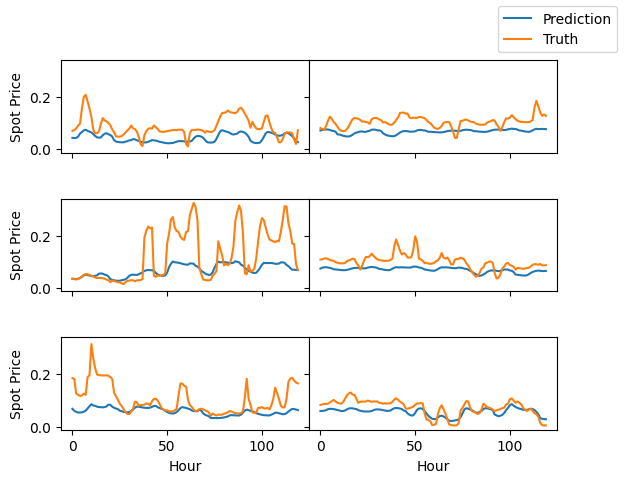

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=2, sharex='all', sharey='all')

for i, data in enumerate(test_windowed.take(6)):
  (past, future), truth = data

  pred = model.predict((past,future)) 

  row = i//2
  col = i%2

  ax[row][col].plot(pred.flatten(), label='Prediction')
  ax[row][col].plot(truth.numpy().flatten(), label='Truth')

# Labeling axes
for i in range(2):
  ax[2][i].set_xlabel('Hour')
for i in range(3):
  ax[i][0].set_ylabel('Spot Price')

handles, labels = ax[0][0].get_legend_handles_labels()
fig.subplots_adjust(wspace=0, hspace=0.5)
fig.legend(handles, labels, loc='upper right')

In [ ]:
scaling_factor = scaler.data_max_[0]
mean = lambda x: x.mean().numpy().flatten() 
sd = lambda x: x.stddev().numpy().flatten()

t = np.array(range(forecast_len))

for i, data in enumerate(test_windowed.take(1)):
    (past, future), truth = data
    truth = truth 

    pred = model((past,future)) 

    plt.fill_between(t, 
                    mean(pred) + 2*sd(pred), 
                    (mean(pred) - 2*sd(pred)).clip(min=0),
                    color = 'green', label = '95% CI', alpha=0.2,
                    linewidth = 2)
    plt.plot(t,mean(pred), label='Prediction', color='lightcoral', linewidth = 2)
    plt.plot(t,truth.numpy().flatten(),label='True value', linewidth = 2)

plt.legend()
plt.show()